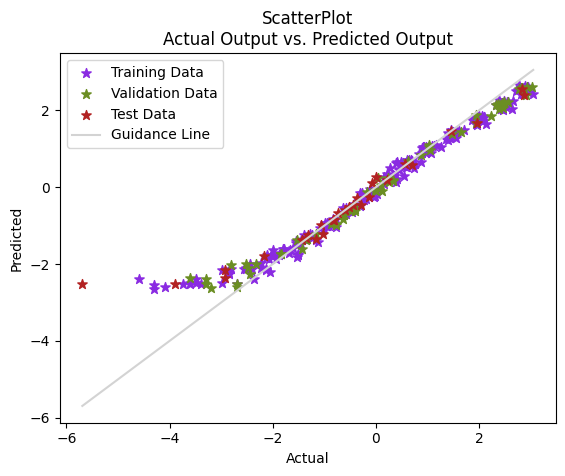

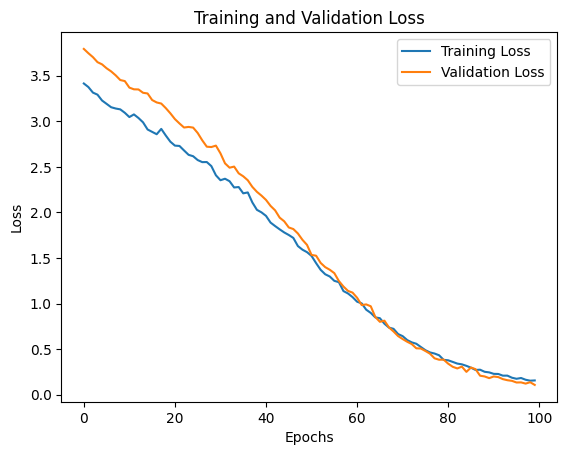

Train Loss: 0.1402018815279007
Validation Loss: 0.10715111345052719
Test Loss: 0.4684380292892456


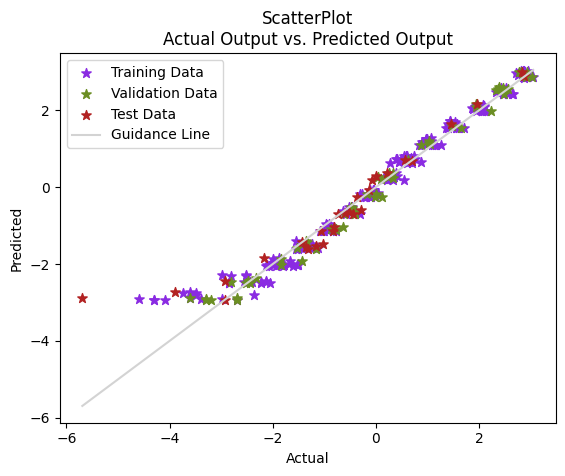

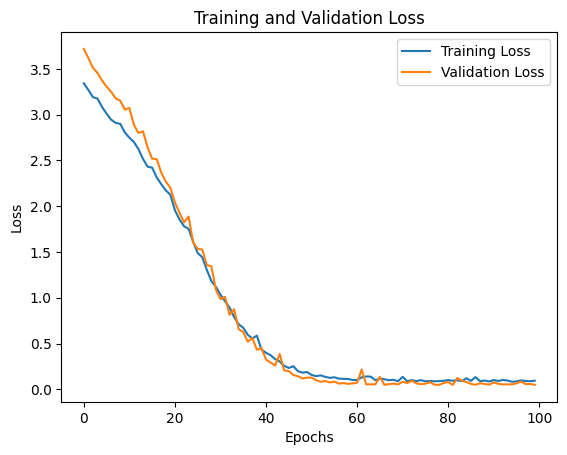

Train Loss: 0.09111088514328003
Validation Loss: 0.04858946055173874
Test Loss: 0.3688022792339325


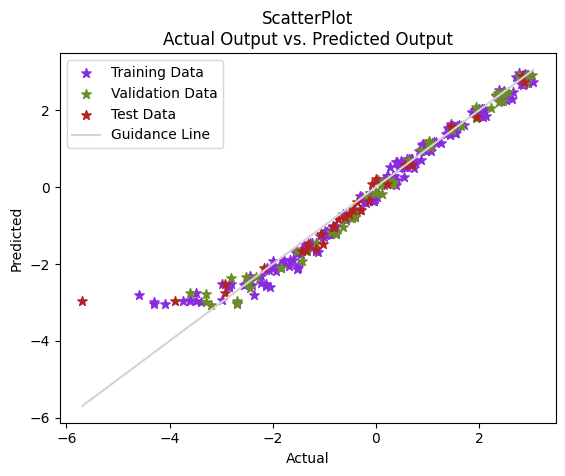

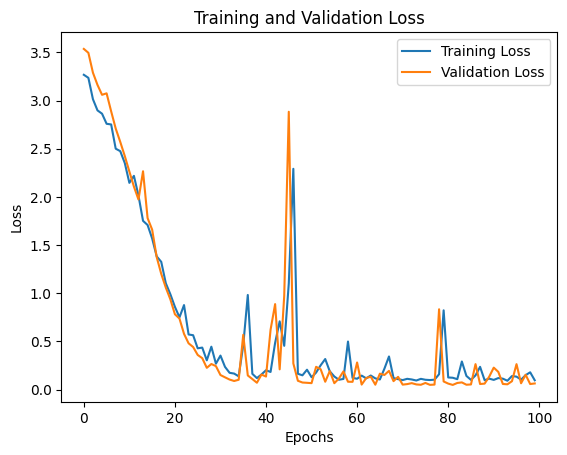

Train Loss: 0.08558182418346405
Validation Loss: 0.06330136954784393
Test Loss: 0.3307971954345703


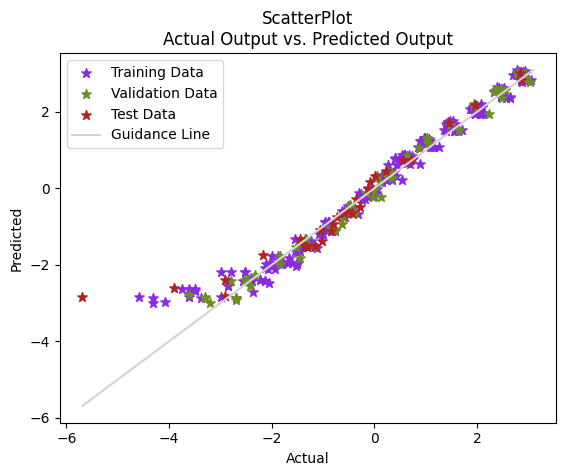

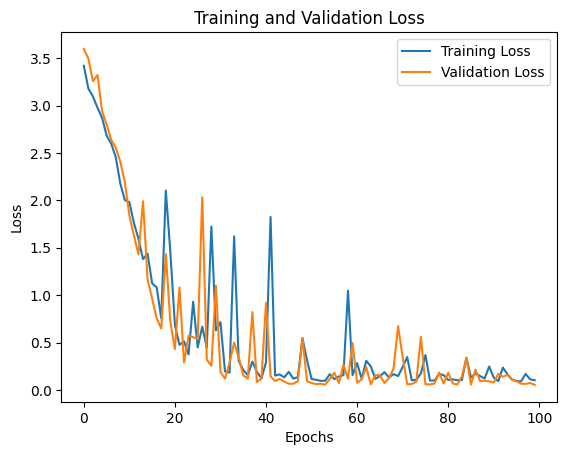

Train Loss: 0.0991535410284996
Validation Loss: 0.05333453044295311
Test Loss: 0.3825322985649109


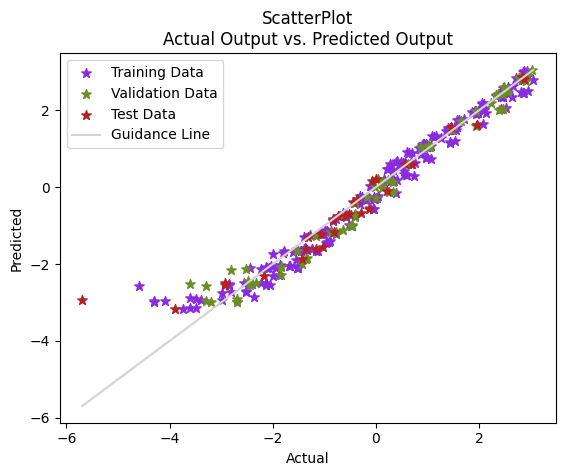

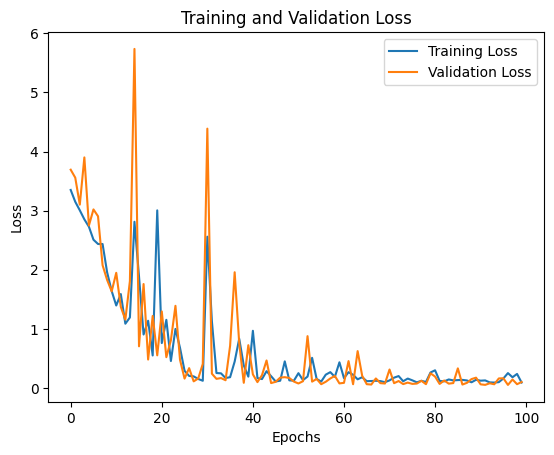

Train Loss: 0.10427271574735641
Validation Loss: 0.10127811133861542
Test Loss: 0.3511126935482025


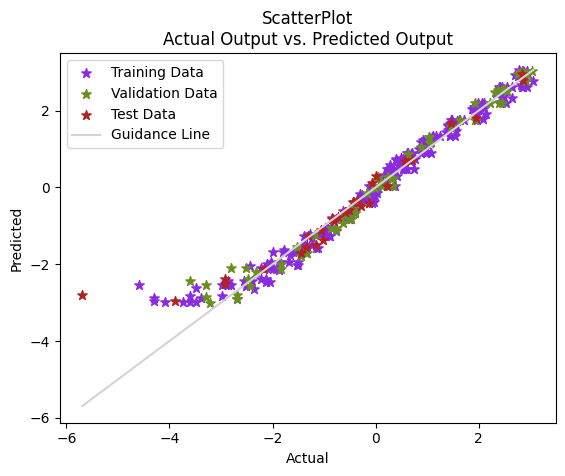

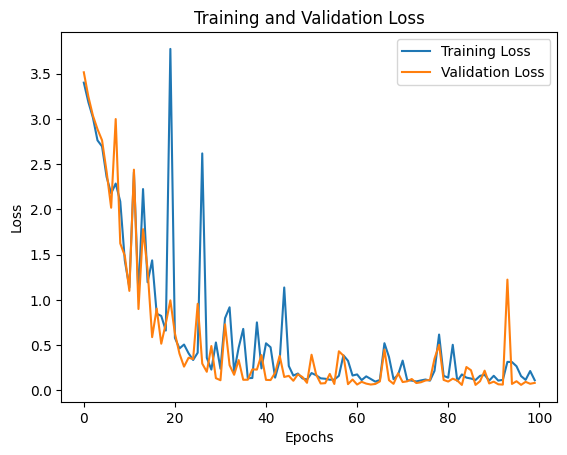

Train Loss: 0.09372023493051529
Validation Loss: 0.08129706978797913
Test Loss: 0.3580847680568695


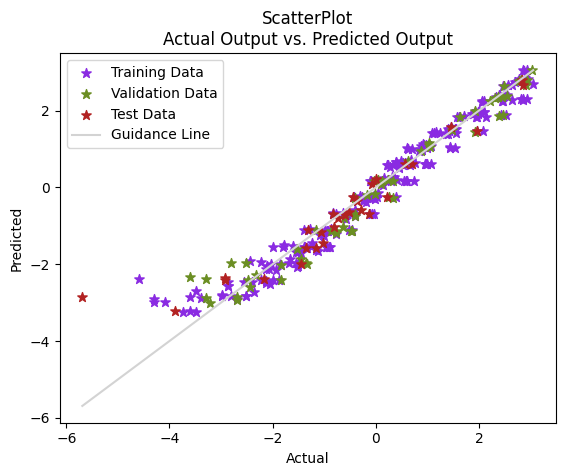

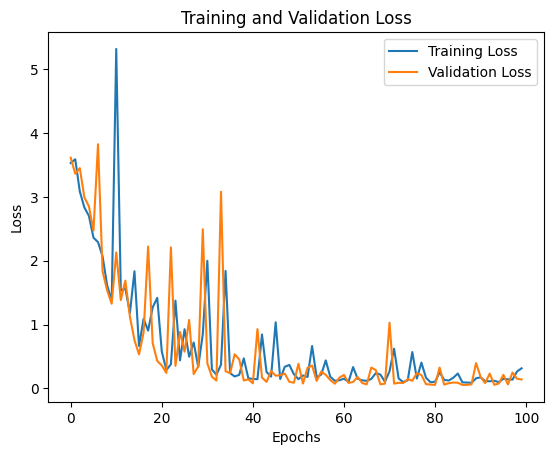

Train Loss: 0.13291412591934204
Validation Loss: 0.139769047498703
Test Loss: 0.38072896003723145


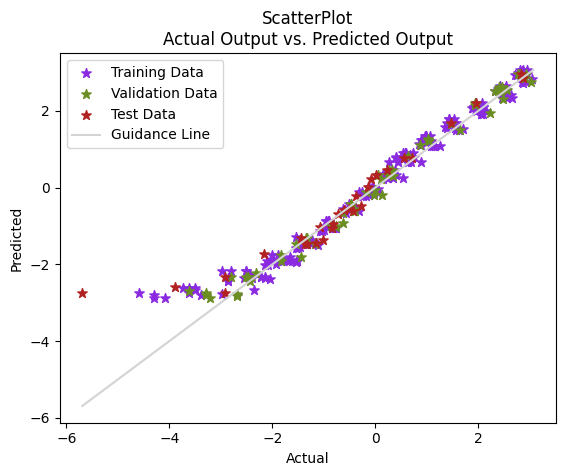

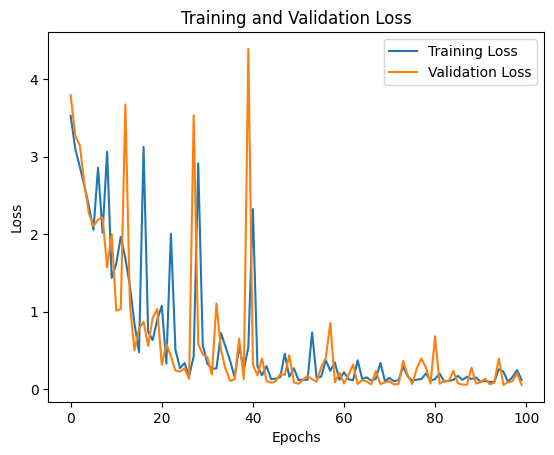

Train Loss: 0.10365141183137894
Validation Loss: 0.0562455952167511
Test Loss: 0.40648606419563293


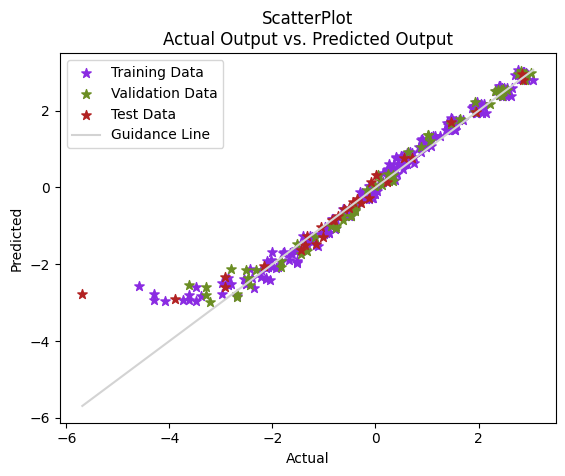

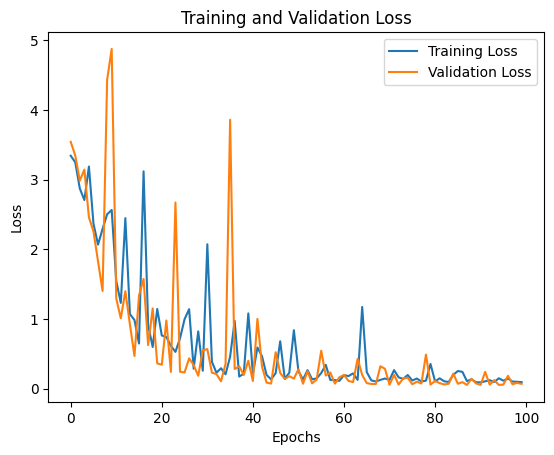

Train Loss: 0.09051179140806198
Validation Loss: 0.06941961497068405
Test Loss: 0.36451607942581177


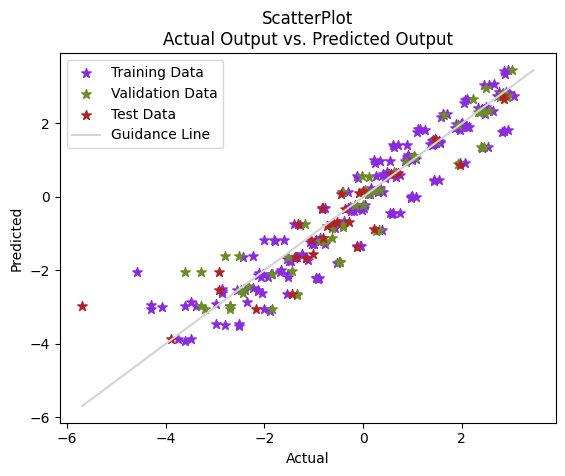

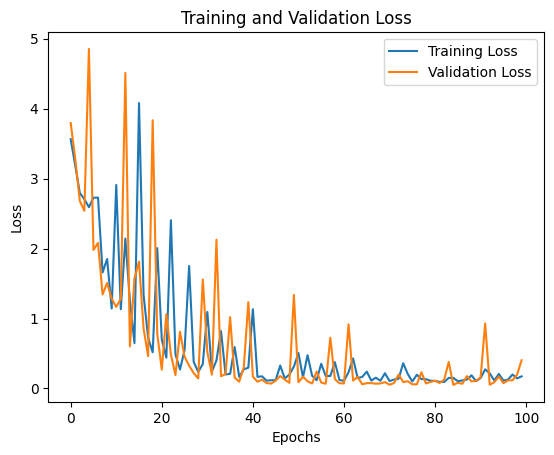

Train Loss: 0.36080747842788696
Validation Loss: 0.4025615453720093
Test Loss: 0.5645902156829834
Index Sample Size  Learning Rate  Train Erms  Validate Erms  Test Erms
    1         215           0.01    0.378992       0.327762   0.684425
    2         215           0.02    0.305473       0.222540   0.607291
    3         215           0.03    0.295812       0.253394   0.575150
    4         215           0.04    0.318042       0.232895   0.618492
    5         215           0.05    0.326079       0.320143   0.592548
    6         215           0.06    0.309884       0.286562   0.598402
    7         215           0.07    0.367024       0.375611   0.617032
    8         215           0.08    0.325544       0.239059   0.637563
    9         215           0.09    0.304935       0.264382   0.603752
   10         215           0.10    0.600639       0.637254   0.751392


In [3]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

column_names = [
    "Index",
    "Sample Size",
    "Learning Rate",
    "Train Erms",
    "Validate Erms",
    "Test Erms",
]
table_index = 0
table_df = pd.DataFrame(columns=column_names)


def add_data_to_table(sample_size, learning_rate, train_erms, validate_erms, test_erms):
    row_data = {}
    global table_df
    global table_index
    table_index = table_index + 1
    row_data["Index"] = table_index
    row_data["Sample Size"] = sample_size
    row_data["Learning Rate"] = learning_rate
    row_data["Train Erms"] = train_erms
    row_data["Validate Erms"] = validate_erms
    row_data["Test Erms"] = test_erms
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        table_df = pd.concat(
            [table_df, pd.DataFrame(row_data, index=[0])], ignore_index=True
        )


def print_table():
    print(table_df.to_string(index=False))

def get_N(x):
    N = len(x)
    return N

def get_erms(y, t):
    train_y_mse = tf.reduce_mean(tf.square(t-y))
    train_erms = np.sqrt(train_y_mse)
    return train_erms

def get_meshgrid(start_x1, stop_x1, start_x2, stop_x2, N):
    x1_range = np.linspace(start_x1, stop_x1, N)
    x2_range = np.linspace(start_x2, stop_x2, N)
    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    
    input_grid = np.column_stack((x1_grid.ravel(), x2_grid.ravel()))

    return (x1_grid, x2_grid, input_grid)

def plot_loss(result):

    # Plot training loss
    plt.plot(result.history['loss'], label='Training Loss')
    plt.plot(result.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def scatter_plot_2d(x, y, x_label, y_label, plot_title, plot_color):
    plt.scatter(x, y, color=plot_color, label=plot_title, marker="*", s=50)
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    # plt.show()

def line_plot(x, y, plot_label, plot_color):
    plt.plot(x, y, color=plot_color, label=plot_label)
    plt.legend()
    # plt.show()

def plot_scatter(
    train_y, train_y_pred, val_y, val_y_pred, test_y, test_y_pred
):
    scatter_plot_2d(train_y, train_y_pred, "Actual", "Predicted", 'Training Data', "blueviolet")

    scatter_plot_2d(val_y, val_y_pred, "Actual", "Predicted", 'Validation Data', "olivedrab")

    scatter_plot_2d(test_y, test_y_pred, "Actual", "Predicted", 'Test Data', "firebrick")

    min_point = min(
        np.min(train_y), np.min(train_y_pred), np.min(test_y), np.min(test_y_pred)
    )
    max_point = max(
        np.max(train_y), np.max(train_y_pred), np.max(test_y), np.max(test_y_pred)
    )

    line_plot((min_point, max_point), (min_point, max_point), "Guidance Line", "lightgray")

    plot_title = (
        "ScatterPlot\nActual Output vs. Predicted Output"
    )
    plt.title(plot_title)
    plt.show()

def plot_graphs(train_x, train_y, val_x, val_y, test_x, test_y, sample_size, learning_rate=0.1):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Define the model architecture
        # Build the model
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='tanh', input_shape=(train_x.shape[1],)),
            # tf.keras.layers.Dense(32, activation='tanh'),
            tf.keras.layers.Dense(1, activation='linear')
        ])
    
    # Compile the model with the specified learning rate
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Train the model
    result = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=100, batch_size=32, verbose=0)
    
    # Evaluate the model on train data
    train_loss = model.evaluate(train_x, train_y, verbose=0)
    # Evaluate the model on validation data
    val_loss = model.evaluate(val_x, val_y, verbose=0)
    # Evaluate the model on test data
    test_loss = model.evaluate(test_x, test_y, verbose=0)

    train_y_pred = model.predict(train_x, verbose=0)
    val_y_pred = model.predict(val_x, verbose=0)
    test_y_pred = model.predict(test_x, verbose=0)
    
    train_erms = get_erms(train_y_pred, train_y)
    validate_erms = get_erms(val_y_pred, val_y)
    test_erms = get_erms(test_y_pred, test_y)
    
    # Plot scatter the graphs
    plot_scatter(train_y, train_y_pred, val_y, val_y_pred, test_y, test_y_pred)
     
    # Plot training loss
    plot_loss(result)

    add_data_to_table(sample_size, learning_rate, train_erms, validate_erms, test_erms)

    # Print train loss
    print("Train Loss:", train_loss)
    # Print validation loss
    print("Validation Loss:", val_loss)
    # Print test loss
    print("Test Loss:", test_loss)
    

def main():
    folder_number = "9"
    current_directory = os.getcwd()
    # regression_dataset_3_path=current_directory+ "/Datasets_for_A1/Regression/Dataset 3/" + folder_number + "/"
    regression_dataset_3_path = (
        "/home/dipendu/programs/mtech_2023/ml/ass1/Datasets_for_A1/Regression/Dataset 3/"
        + folder_number
        + "/"
    )

    regression_dataset_3_Train_data = regression_dataset_3_path + "train_data.csv"
    df = pd.read_csv(regression_dataset_3_Train_data)
    data = df.to_numpy()
    train_x = data

    regression_dataset_3_Train_label = regression_dataset_3_path + "train_label.csv"
    df = pd.read_csv(regression_dataset_3_Train_label)
    data = df.to_numpy()
    train_y = data

    regression_dataset_3_Validation_data = regression_dataset_3_path + "val_data.csv"
    df = pd.read_csv(regression_dataset_3_Validation_data)
    data = df.to_numpy()
    val_x = data

    regression_dataset_3_Validation_label = regression_dataset_3_path + "val_label.csv"
    df = pd.read_csv(regression_dataset_3_Validation_label)
    data = df.to_numpy()
    val_y = data

    regression_dataset_3_Test_data = regression_dataset_3_path + "test_data.csv"
    df = pd.read_csv(regression_dataset_3_Test_data)
    data = df.to_numpy()
    test_x = data

    regression_dataset_3_Test_label = regression_dataset_3_path + "test_label.csv"
    df = pd.read_csv(regression_dataset_3_Test_label)
    data = df.to_numpy()
    test_y = data

    accuracy_factor = 100.0
    iterations = 11

    sample_size = get_N(train_x)
    for i in range(1, iterations):
        learning_rate = i/accuracy_factor
        plot_graphs(
            train_x,
            train_y,
            val_x,
            val_y,
            test_x,
            test_y,
            sample_size,
            learning_rate,
        )

    print_table()


if __name__ == "__main__":
    main()